In [1]:
import dill
from dotdict import DotAccessibleDict
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
from scipy.io import wavfile
import librosa
import torch.nn.functional as F
import scipy
import random
import os

In [2]:
def process_file(file_path):
    config = DotAccessibleDict({
    'hop_length': 44,
    'conv1_kernel_size': (3,7),
    'conv2_kernel_size': (3,3),
    'conv2_dimensions': 20,
    'conv_out_dimensions': 50,
    'linear_out': 256,
    'n_mels': 80,
    'learning_rate': 0.00001,
    'batch_size': 40
    })


    with open("cnn_output.dmp", "rb") as dmp_file:
        model = dill.load(dmp_file)
        model.cuda()

    def full_file_dataset(file_path, n_fft=[4096, 2048, 1024], hop_length=config.hop_length, n_mels=config.n_mels):
        sample_rate, audio = wavfile.read(file_path)
        if audio.dtype.kind == 'i':
            audio = audio.astype(float) / np.iinfo(audio.dtype).max
        if audio.ndim == 2:
            audio = np.mean(audio, axis=1)
        
        spectrograms = []
        for n_fft_option in n_fft:
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft_option, hop_length=hop_length, n_mels=n_mels)
            log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrograms.append(log_spectrogram)
        
        stacked_spectrograms = np.stack(spectrograms, axis=0)
        return torch.tensor(stacked_spectrograms, dtype=torch.float32), sample_rate

    def smooth_data(data, window_length=15):
        """Smooth the data using a moving average."""
        #somewhat gaussian window...
        window = np.array([0.01, 0.02,0.02,0.05,0.05,0.15, 0.15 ,0.15, 0.15, 0.15, 0.05, 0.05, 0.02, 0.02, 0.01])
        #window = np.ones(window_length)
        return np.convolve(data, window, mode='same')

    def find_peaks(data, threshold=0.5):
        """Find peaks above a specified threshold."""
        peaks, _ = scipy.signal.find_peaks(data, height=threshold)
        return peaks


    def evaluate_model_on_full_file(model, audio_tensor, step_offset=7):
        model.eval()
        num_chunks = audio_tensor.shape[2] - step_offset
        predictions = np.zeros(num_chunks)
        with torch.no_grad():
            # Process audio in chunks of size `sample_length`
            for i in range(step_offset, num_chunks - step_offset - 1):
                chunk = audio_tensor[:, :, i-step_offset : i + step_offset + 1]
                output = model(chunk.unsqueeze(0).cuda())
                predicted_prob = torch.sigmoid(output).cpu().numpy()
                predictions[i] = predicted_prob
        return np.array(predictions)


    def load_correct_labels(onset_file, total_frames, frame_duration):
        if not os.path.exists(onset_file):
            return None
        with open(onset_file, 'r') as f:
            onsets = np.array([float(line.strip()) for line in f if line.strip()], dtype=np.float32)
        labels = np.zeros(total_frames, dtype=np.float32)
        frame_onsets = np.floor(onsets / frame_duration).astype(int)
        labels[frame_onsets] = 1.0
        return labels

    # Load the audio file and its labels
    audio_tensor, sample_rate = full_file_dataset(file_path)
    onset_labels = load_correct_labels(file_path.replace(".wav", ".onsets.gt"), audio_tensor.shape[2], config.hop_length / sample_rate)

    # Generate predictions
    predictions = evaluate_model_on_full_file(model, audio_tensor)
    normalized_predictions = np.maximum(0,((predictions - 0.5)/np.max(predictions - 0.5)))

    smoothed_predictions = smooth_data(normalized_predictions)
    threshold_value = 0.8 * np.max(smoothed_predictions)
    peak_indices = find_peaks(smoothed_predictions, threshold=threshold_value) - 3
    
    peak_times = peak_indices * (config.hop_length / sample_rate)
    return normalized_predictions, peak_indices, peak_times, onset_labels, audio_tensor[0]

In [3]:
def evaluate(predicted_onsets, true_onsets):
    tolerance = 2
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    diff = 0
    for pred in predicted_onsets:
        if any(abs(pred - true) <= tolerance for true in true_onsets):
            true_positives += 1
        else:
            if any(abs(pred - 20) <= tolerance for true in true_onsets):
                diff += pred - tolerance
            false_positives += 1

    for true in true_onsets:
        if not any(abs(true - pred) <= tolerance for pred in predicted_onsets):
            false_negatives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Length of predictions: {len(predicted_onsets)}")
    print(f"Lenth of true onsets: {len(true_onsets)}")
    print(f"F1-score: {f1_score}")
    print(f"{true_positives} | {false_negatives}")
    print(f"{false_positives} | infty")


In [4]:
file_path ='data/train_extra_onsets/lame_iron.wav'
detection_function, predicted_onsets, predicted_onset_times, onset_labels, mel_spect = process_file(file_path)
true_onsets = list(np.argwhere(onset_labels!=0).squeeze())
evaluate(predicted_onsets, true_onsets)

Length of predictions: 179
Lenth of true onsets: 200
F1-score: 0.5329815303430079
101 | 99
78 | infty


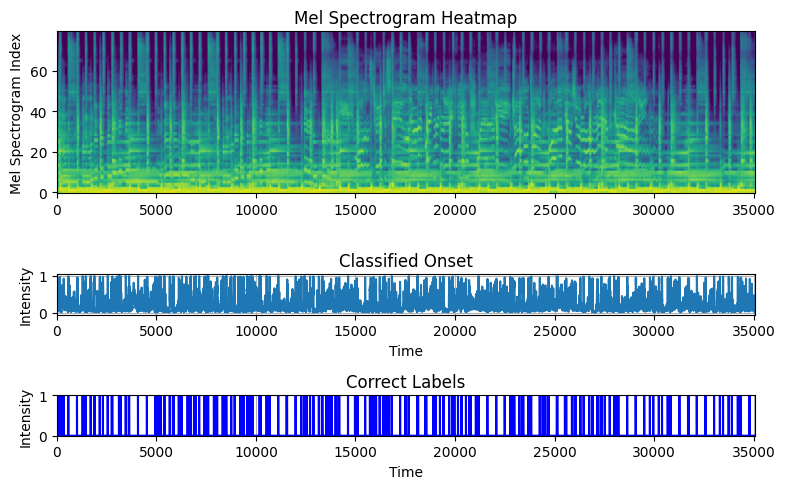

In [5]:
# Plotting the results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 5), height_ratios=[1, 0.25, 0.25])

# Plot Mel Spectrogram Heatmap
ax1.imshow(mel_spect, aspect='auto', cmap='viridis', origin='lower')
ax1.set_ylabel('Mel Spectrogram Index')
ax1.set_title('Mel Spectrogram Heatmap')
ax1.grid(False)

# Plot Predicted Onsets
ax2.plot(detection_function)
ax2.set_xlabel('Time')
ax2.set_ylabel('Intensity')
ax2.set_title('Classified Onset')
ax2.set_xlim(ax1.get_xlim())

predicted_labels = np.zeros_like(onset_labels)
predicted_labels[predicted_onsets] = 1
#ax2.plot(predicted_labels, c="red", label="predicted")

# Plot Correct Labels
ax3.plot(onset_labels, c="blue", label="correct")
ax3.set_xlabel('Time')
ax3.set_ylabel('Intensity')
ax3.set_ylim(0,1)
ax3.set_title('Correct Labels')
ax3.set_xlim(ax1.get_xlim())

# Add grid and layout adjustments
ax2.grid(True)
ax3.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import os
from tqdm import *

In [7]:
dataset="train"
files = [os.path.join(f"data/{dataset}", f) for f in os.listdir(f"data/{dataset}") if f.endswith('.wav')]
output_json = {}

for f in tqdm(range(len(files))):
    _, _, onset_times, _, _ = process_file(files[f])
    output_json[files[f].replace(f"data/{dataset}\\", "").replace(".wav", "")] = {
        "onsets": list(onset_times),
        "tempo": [],
        "beats":[]
        }
    print(f"Done {files[f]}")
output_json

  1%|          | 1/127 [00:13<29:17, 13.95s/it]

Done data/train\ff123_2nd_vent_clip.wav


  2%|▏         | 2/127 [00:30<32:04, 15.39s/it]

Done data/train\ff123_41_30sec.wav


  2%|▏         | 3/127 [00:40<27:13, 13.17s/it]

Done data/train\ff123_ATrain.wav


  2%|▏         | 3/127 [00:42<29:33, 14.30s/it]


KeyboardInterrupt: 

In [10]:
len(output_json["ff123_41_30sec"]["onsets"])

233

In [18]:
import json
with open("I_need_more_sleep_submission.json", "w") as eval_file:
    eval_file.write(json.dumps(output_json))
output_json

{'test01': {'onsets': [0.00798185941043084,
   0.5357823129251701,
   0.5487528344671202,
   0.9967346938775511,
   1.4227664399092972,
   1.8557823129251703,
   2.2528798185941046,
   2.264852607709751,
   3.1189115646258507,
   3.148843537414966,
   3.1678004535147393,
   3.195736961451247,
   3.568888888888889,
   3.581859410430839,
   3.99092970521542,
   4.432925170068027,
   4.85297052154195,
   5.308934240362812,
   5.451609977324264,
   5.469569160997732,
   5.543401360544218,
   5.639183673469388,
   5.674104308390023,
   5.711020408163265,
   5.782857142857143,
   5.790839002267574,
   5.895600907029479,
   5.9464852607709755,
   6.188934240362812,
   6.394467120181407,
   6.4962358276644,
   6.5560997732426305,
   6.586031746031747,
   7.015056689342404,
   7.046984126984127,
   7.436099773242631,
   7.8212244897959184,
   7.915011337868481,
   7.944943310657597,
   7.9629024943310664,
   7.988843537414967,
   8.014784580498867,
   8.062675736961452,
   8.114557823129251,
  